In [11]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded.keys())))

Saving MiningProcess_Flotation_Plant_Database.csv to MiningProcess_Flotation_Plant_Database (1).csv


In [12]:
# Convert the first column to datetime with error handling and set as index
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
df = df.dropna(subset=[df.columns[0]])  # remove rows with invalid dates
df = df.set_index(df.columns[0])

# Replace commas with periods and convert numeric columns, coercing errors
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Original Shape:", df.shape)
print(df.head())

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Original Shape: (737453, 23)
                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
date                                                                       
2017-03-10 01:00:00         55.2          16.98      3019.53     557.434   
2017-03-10 01:00:00         55.2          16.98      3024.41     563.965   
2017-03-10 01:00:00         55.2          16.98      3043.46     568.054   
2017-03-10 01:00:00         55.2          16.98      3047.36     568.665   
2017-03-10 01:00:00         55.2          16.98      3033.69     558.167   

                     Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
date                                                                
2017-03-10 01:00:00        395.713      10.0664              1.74   
2017-03-10 01:00:00        397.383      10.0672              1.74   
2017-03-10 01:00:00        399.668      10.0680              1.74   
2017-03-10 01:00:00        397.939      10.0689              1.74   
2017-03-10 01:00:00     

In [13]:
def train_and_evaluate(dataframe, target_col, drop_cols=[], model=None):
    X = dataframe.drop(columns=[target_col] + drop_cols)
    y = dataframe[target_col]

    # Ensure there are enough rows for splitting
    if len(dataframe) < 5:
        raise ValueError("Not enough rows for training. Need at least 5 rows.")


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    if model is None:
        model = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        "model": model,
        "r2": r2_score(y_test, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred))
    }

In [14]:
target_col = df.columns[-1]  # Assuming last column is silica

# 7. Predict every minute using the original df
result_minute = train_and_evaluate(df, target_col)
print(f"\nPrediction every minute -> R²: {result_minute['r2']:.3f}, RMSE: {result_minute['rmse']:.3f}")


Prediction every minute -> R²: 0.495, RMSE: 0.814


In [15]:
# 8. Function for forecasting hours ahead
def shift_target(dataframe, target, hours_ahead):
    df_shifted = dataframe.copy()
    df_shifted[target] = df_shifted[target].shift(-hours_ahead*60)  # shift in minutes
    return df_shifted.dropna()

for h in [1, 2, 4]:
    print(f"Starting prediction for {h}h ahead...")
    shifted_df = shift_target(df, target_col, h)
    res = train_and_evaluate(shifted_df, target_col)
    print(f"Predict {h}h ahead -> R²: {res['r2']:.3f}, RMSE: {res['rmse']:.3f}")

Starting prediction for 1h ahead...
Predict 1h ahead -> R²: 0.425, RMSE: 0.868
Starting prediction for 2h ahead...
Predict 2h ahead -> R²: 0.345, RMSE: 0.927
Starting prediction for 4h ahead...
Predict 4h ahead -> R²: 0.244, RMSE: 0.996


In [16]:
# 9. Evaluate model without iron concentrate column
iron_col = [col for col in df.columns if "iron" in col.lower()]
if iron_col:
    result_no_iron = train_and_evaluate(df, target_col, drop_cols=iron_col)
    print(f"\nWithout % Iron Concentrate -> R²: {result_no_iron['r2']:.3f}, RMSE: {result_no_iron['rmse']:.3f}")
else:
    print("\nNo Iron Concentrate column found in dataset.")


Without % Iron Concentrate -> R²: -0.354, RMSE: 1.332


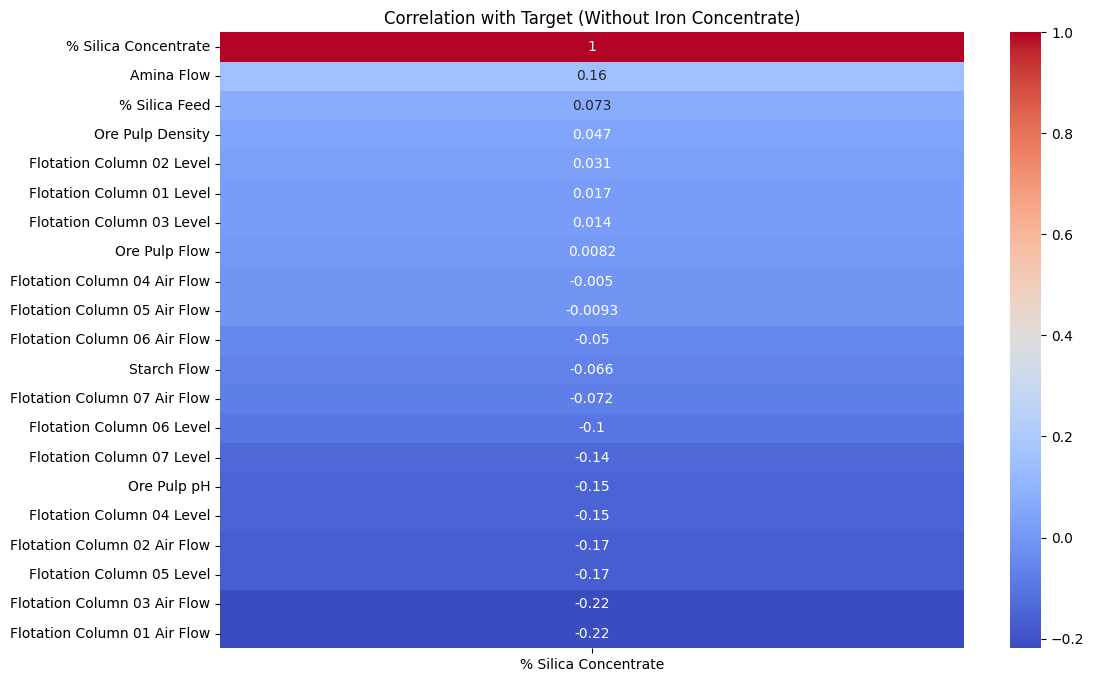

Top features for lag creation: ['Flotation Column 01 Air Flow', 'Flotation Column 03 Air Flow', 'Flotation Column 05 Level', 'Flotation Column 02 Air Flow', 'Amina Flow']


In [17]:
import joblib
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

iron_col = [col for col in df.columns if "iron" in col.lower()]
df_no_iron = df.drop(columns=iron_col, errors='ignore')

plt.figure(figsize=(12,8))
sns.heatmap(df_no_iron.corr()[[target_col]].sort_values(by=target_col, ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation with Target (Without Iron Concentrate)")
plt.show()

def create_lags(dataframe, cols, lags):
    df_lagged = dataframe.copy()
    for col in cols:
        for lag in lags:
            df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

top_features = df_no_iron.corr()[target_col].abs().sort_values(ascending=False).index[1:6]
print("Top features for lag creation:", top_features.tolist())